In [1]:
import numpy as np

import ase
import spglib

from ase import build
from uf3.forcefield import lammps
from uf3.util import elastic
from uf3.util import phonon

# Initialize LAMMPS

In [2]:
calc = lammps.UFLammps(lmpcmds=["pair_style table spline 50",
                                "pair_coeff * * table_test/W.table UF_W-W 5.5"],
                       keep_alive=True)

# Build BCC and relax (2 atoms)

In [3]:
element = 'W'
geom = build.bulk(element, 'bcc', a=2.5, cubic=True)
geom.calc = calc
calc.relax(geom)

In [4]:
a0 = np.mean(np.diag(geom.cell.array))
print("Lattice constant: {0:.3f} angstroms".format(a0))

Lattice constant: 3.158 angstroms


# Get primitive cell (1 atom)

In [5]:
lattice, scaled_positions, numbers = spglib.standardize_cell(geom,
                                                             to_primitive=True,
                                                             no_idealize=False,
                                                             symprec=1e-5)
geom = ase.Atoms(cell=lattice,
                 scaled_positions=scaled_positions,
                 numbers=numbers,
                 pbc=(True, True, True))

# Get elastic constants

In [6]:
constants = elastic.get_elastic_constants(geom, calc)

print('Cij (GPa):', constants[:-1])
print('B (GPa):', constants[-1])

Cij (GPa): [557.7755729634257, 175.13635072917526, 182.79639225833319]
B (GPa): 299.2575511071246


# Get Phonon Spectra

(0.0, 7.0)

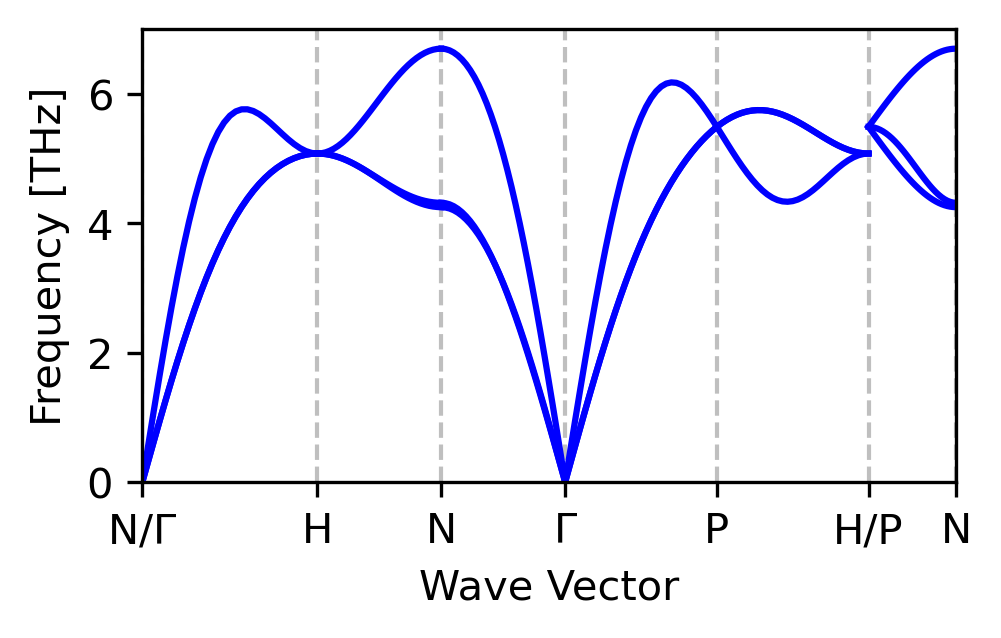

In [7]:

force_constants, path_data, bands_dict = phonon.compute_phonon_data(geom,
                                                                    calc,
                                                                    n_super=5,
                                                                    disp=0.05)
fig, ax = phonon.plot_phonon_spectrum(path_data, bands_dict, color='blue')
ax.set_xlim(0, 1)
ax.set_ylim(0, 7)

# Cleanup LAMMPS

In [8]:
del calc